In [1]:
%matplotlib widget

import os
from pathlib import Path
import hashlib
from typing import Optional, Iterable
from PIL import Image
import io

import ipywidgets as widgets
from IPython.display import display, clear_output

import matplotlib.pyplot as plt

import numpy as np

from skimage.filters import threshold_otsu

In [2]:
models_path = Path('/Users/karan/microsegmentation/Models')
demos_path = Path('/Users/karan/microsegmentation/DemoData')
inferences_path = Path("/Users/karan/microsegmentation/.inference_save_files")

images_path = demos_path / 'Images'
labels_path = demos_path / 'Masks'

In [3]:
model_name = ""
image_name = ""

model_dropdown = None
image_dropdown = None

image_widget = None
label_widget = None

segmentation_widget = None

hard_segmentation_widget = None

hard_segmentation_threshold_slider = None
otsu_button = None
log_scale_histogram_widget = None

log_hist_fig, log_hist_axs = None, None

metrics_df = None

In [4]:
hard_segmentation = None
segmentation = None

image_png = None
label_png = None

image = None
label = None

In [5]:
def numpy_to_image_data(np_image):
    np_image = (np_image * 255.).astype(np.uint8)

    pil_image = Image.fromarray(np_image)
    with io.BytesIO() as output:
        pil_image.save(output, format="PNG")
        return output.getvalue()

In [6]:
def _file_content_hash(file_path : Path) -> str:
    """Generate a hash for the file content"""
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

def hash_files(files : Iterable[Path]) -> str:
    raw_input = ("_".join(map(_file_content_hash, files))).encode()
    hashed = hashlib.md5(raw_input).hexdigest()

    return hashed

def get_segmentation_file_path(output_dir : Path,
                               model_file_path : Path,
                               image_file_path : Path) -> Path:
    file_key = hash_files([model_file_path, image_file_path])
    file_path = output_dir / f"segmentation_{file_key}.npy"
        
    return file_path

def query_inference():
    global segmentation

    global image_png, label_png
    global image, label

    model_file_path = models_path / model_name / 'model.pth'

    image_file_path = images_path / f"{image_name}.png"
    label_file_path = labels_path / f"{image_name}.png"

    if image_file_path.exists():
        with open(image_file_path, 'rb') as image_file:
            image_png = image_file.read()

        image = np.array(Image.open(image_file_path).convert('L'))

    if label_file_path.exists():
        with open(label_file_path, 'rb') as label_file:
            label_png = label_file.read()

        label = np.array(Image.open(label_file_path).convert('L'))
        label[label == 255] = 1

    if not (model_file_path.exists() and image_file_path.exists()):
        return 
    
    file_path = get_segmentation_file_path(output_dir=inferences_path,
                                           model_file_path=model_file_path,
                                           image_file_path=image_file_path)

    if file_path.exists():
        segmentation = np.load(file_path)

    

In [7]:
def update_displays():
    global hard_segmentation
    global metrics_df

    query_inference()

    # print("Updating displays...")
    if image_png is not None:
        image_widget.value = image_png
    
    if label_png is not None:
        label_widget.value = label_png

    if segmentation is None:
        return

    segmentation_widget.value = numpy_to_image_data(segmentation)

    hard_segmentation_threshold = hard_segmentation_threshold_slider.value
    hard_segmentation = np.where(segmentation < hard_segmentation_threshold, 0, 1).astype(np.uint8)

    hard_segmentation_widget.value = numpy_to_image_data(hard_segmentation)

    hard_segmentation_threshold_slider.min = segmentation.min()
    hard_segmentation_threshold_slider.max = segmentation.max()

    log_hist_axs.cla()
    log_hist_axs.hist(segmentation.flatten())
    log_hist_axs.set_yscale('log')

    log_hist_axs.axvline(x=hard_segmentation_threshold, color='red', linestyle='--', linewidth=2)

    log_hist_fig.canvas.draw()
    log_hist_fig.canvas.flush_events()

    dice_coefficient = float(2 * (label * hard_segmentation).sum()) / (label.sum() + hard_segmentation.sum())
    bce_1to1 = -(0.5 * label.astype(float) * np.log(segmentation) + 0.5 * (1.-label.astype(float)) * np.log(1 - segmentation)).mean()
    bce_9to1 = -(0.9 * label.astype(float) * np.log(segmentation) + 0.1 * (1.-label.astype(float)) * np.log(1 - segmentation)).mean()

    # metrics_df.at[model_name, 'Dice Coefficient'] = dice_coefficient
    # metrics_df.at[model_name, 'BCE (1 : 1)'] = bce_1to1
    # metrics_df.at[model_name, 'BCE (9 : 1)'] = bce_9to1

    metrics_df.at[(model_name, image_name),'Dice Coefficient'] = dice_coefficient
    metrics_df.at[(model_name, image_name),'BCE (1 : 1)'] = bce_1to1
    metrics_df.at[(model_name, image_name),'BCE (9 : 1)'] = bce_9to1

    update_metrics_widget(metrics_df)
    

In [8]:
# Get the list of all folders in the directory
folders = [f for f in os.listdir(models_path) if os.path.isdir(os.path.join(models_path, f))]

model_name = folders[0]

# Create a dropdown widget with the folder names
model_dropdown = widgets.Dropdown(
    options=folders,
    value=None,  # Set default to first folder, if any
    description='Select model:',
    disabled=False,
    style={'description_width': 'initial'},
)

# Define a function to handle the dropdown change event
def on_value_change(change):
    global model_name
    model_name = change['new']

    update_displays()

# Attach the event handler to the dropdown
model_dropdown.observe(on_value_change, names='value')

# Display the dropdown
display(model_dropdown)

Dropdown(description='Select model:', options=('heather_shallow', 'martha_fast_lr', 'heather_s1', 'heather_sha…

In [9]:
# Get the list of all folders in the directory
folders = [f[:-4] for f in os.listdir(images_path) if f.endswith('.png')]


# Create a dropdown widget with the folder names
image_dropdown = widgets.Dropdown(
    options=folders,
    value=None,  # Set default to first folder, if any
    description='Select image:',
    disabled=False,
    style={'description_width': 'initial'},
)

# Define a function to handle the dropdown change event
def on_value_change(change):
    global image_name

    image_name = change['new']

    update_displays()

# Attach the event handler to the dropdown
image_dropdown.observe(on_value_change, names='value')

# Display the dropdown
display(image_dropdown)

Dropdown(description='Select image:', options=('polymerised_rh', 'low_res_image-1', 'ablation_study', 'ablatio…

## Image

In [10]:
image_widget = widgets.Image(
    value=numpy_to_image_data(np.random.random(size=(100,100))),
    format='png',
)

display(image_widget)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x00\x00\x00\x00U\x89\xca\x88\x…

## Label

In [11]:
label_widget = widgets.Image(
    value=numpy_to_image_data(np.random.random(size=(100,100))),
    format='png',
)

display(label_widget)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x00\x00\x00\x00U\x89\xca\x88\x…

## Soft Segmentation

In [16]:
segmentation_widget = widgets.Image(
    value=numpy_to_image_data(np.random.random(size=(100,100))),
    format='png',
)

display(segmentation_widget)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x00\x00\x00\x00U\x89\xca\x88\x…

## Hard Segmentation

In [13]:
hard_segmentation_widget = widgets.Image(
    value=numpy_to_image_data(np.random.random(size=(100,100))),
    format='png',
)

hard_segmentation_threshold_slider = widgets.FloatSlider(
    value=0.5,   # Initial value
    min=0.0,     # Minimum value
    max=1.0,     # Maximum value
    step=0.01,   # Step size for the slider
    description='Threshold:',
    continuous_update=False  # Only update when slider stops moving
)

# Create a text box that allows typing the value
hard_segmentation_threshold_text = widgets.FloatText(
    value=0.5,
    description='Enter value:',
)

# Link the slider and the text box
widgets.jslink((hard_segmentation_threshold_slider, 'value'), (hard_segmentation_threshold_text, 'value'))

hard_segmentation_threshold_slider.observe(lambda change: update_displays(), names='value')

display(hard_segmentation_widget)
display(hard_segmentation_threshold_slider)
display(hard_segmentation_threshold_text)

# Define the function to be called
def on_button_click(b):
    query_inference()
    if segmentation is None:
        return
    
    hard_segmentation_threshold_slider.value = threshold_otsu(segmentation.flatten())

    update_displays()

# Create a button widget
otsu_button = widgets.Button(description="Use Otsu threshold")

# Link the button click event to the function
otsu_button.on_click(on_button_click)

# Display the button
display(otsu_button)

Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x00d\x08\x00\x00\x00\x00U\x89\xca\x88\x…

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0, step=0.01)

FloatText(value=0.5, description='Enter value:')

Button(description='Use Otsu threshold', style=ButtonStyle())

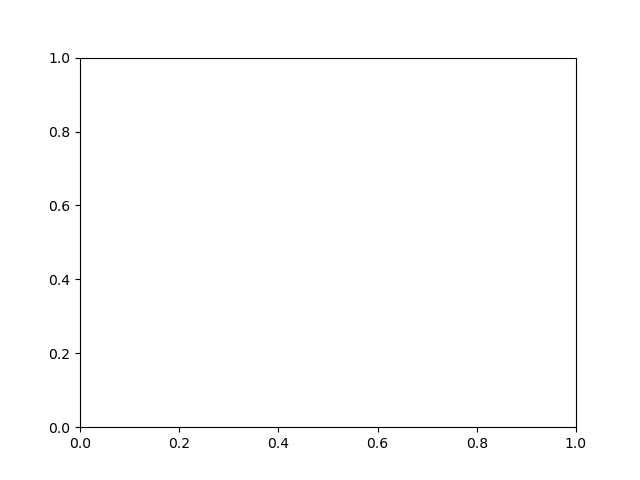

In [14]:
plt.ion()
log_hist_fig, log_hist_axs = plt.subplots()

In [15]:
import pandas as pd

# Sample data

# Create a DataFrame
# metrics_df = pd.DataFrame({
#     'Dice Coefficient': [],
#     'BCE (1 : 1)': [],
#     'BCE (9 : 1)': [],
# })

metrics_df = pd.DataFrame({
        'Model': [],
        'Image': [],
})

metrics_df.set_index(['Model', 'Image'], inplace=True)

metrics_widget = widgets.Output()
display(metrics_widget)

def update_metrics_widget(df):
    global metrics_widget

    with metrics_widget:
        metrics_widget.clear_output(wait=True)  # Clear previous output
        display(df)

# Display the table
update_metrics_widget(metrics_df)


Output()

In [17]:
segmentation